---
layout: post
title:  "Visualising with Basemap"
description: "Plotting DES institutions in a beautiful way"
date: 2019-08-10
categories: [tutorial]
tags: [plotting]
loc: 'tutorials/desinstitutions/'
permalink: /tutorials/des_instituions
math: true
---

!!!replace

I'm scheduled to give a talk for the Dark Energy Survey - a massive collection of researchers, engineers and institutions working together to try and constrain the nature of Dark Energy. To help give my presentations some pizzaz, I thought it would be nice to visualise the spread of institutions around the world that makes DES the wonderful organisation that it is.

## Wheres the data

Unfortunately... I had to collect it by hand. Going through the DES website, writing down each partner, manually gettings its latitude and longitude (yes I know there's an API, but that would have taken longer). You can find it [here](/static/notebooks/desinstitutions/institutions.csv).

In [6]:
import pandas as pd
data = pd.read_csv("desinstitutions\institutions.csv")
data.head()

,shortname,longname,long,lat,country
0,Fermilab,Fermi National Accelerator Laboratory,41.840944,-88.279393,US
1,Chicago,University of Chicago,41.788536,-87.598960,US
2,UIUC,University of Illinois,41.865848,-87.645245,US
3,NCSA,National Center for Supercomputing Applications,40.115045,-88.224302,US
4,LBNL,Lawrence Berkeley National Laboratory,37.875526,-122.252252,US


## Using basemap

Le's start with just a generic outline.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


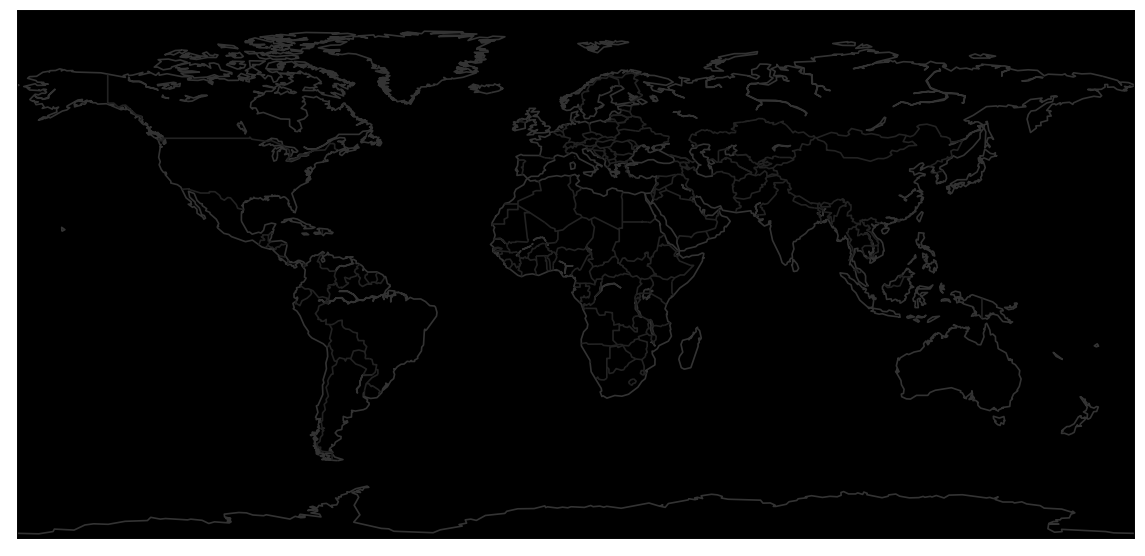

In [2]:
import os
# Sorry about this, shouldn't have install it in the root env, but ah well
os.environ['PROJ_LIB'] = r'C:\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def get_base_fig():
    # Lets define some colors
    bg_color = "#000000"
    coast_color = "#333333"
    country_color = "#222222"
    plt.figure(figsize=(12, 6))

    m = Basemap(projection='cyl', llcrnrlat=-80,urcrnrlat=90, 
                llcrnrlon=-170, urcrnrlon=190, area_thresh=10000.)
    m.fillcontinents(color=bg_color, lake_color=bg_color, zorder=-2)
    m.drawcoastlines(color=coast_color, linewidth=1.0, zorder=-1)
    m.drawcountries(color=country_color, linewidth=1.0, zorder=-1)
    m.drawmapboundary(fill_color=bg_color, zorder=-2)
    return m

get_base_fig();

Great. It a pain to remove the larger rivers, involves downloading a new shape file, so we'll live with it.

# Add the dots

Let's see what it looks like if we just add some dots, with each country having a unique colour.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


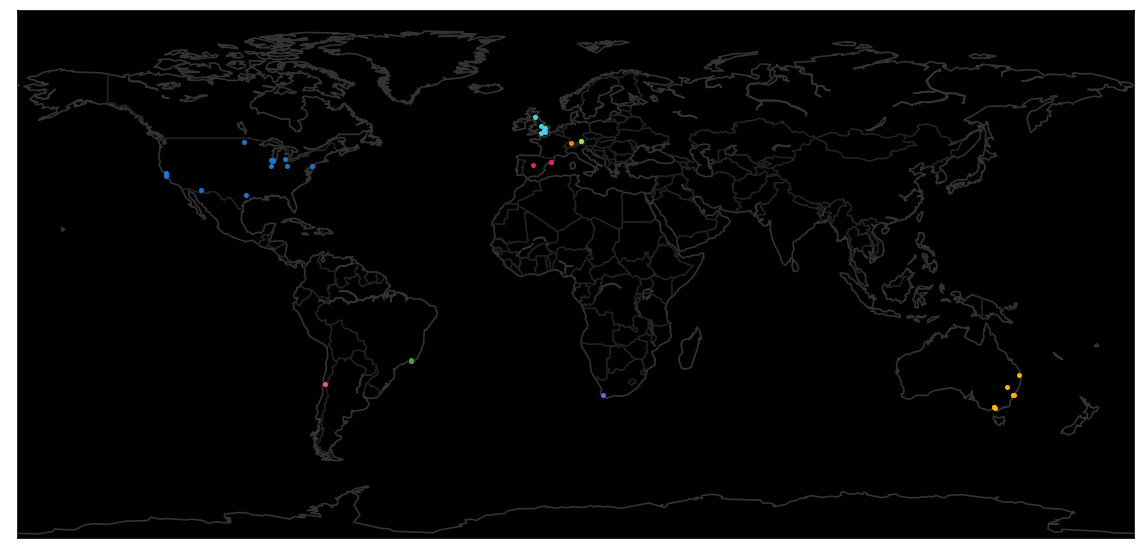

In [3]:
import numpy as np

colors = {
    "Australia": "#FFB300",
    "US": "#1976D2",
    "UK": "#4DD0E1",
    "Germany": "#98e63e",
    "Spain": "#E91E63",
    "Switzerland": "#FB8C00",
    "Brazil": "#43A047",
    "South Africa": "#8956e3",
    "Chile": "#f74f98"
}

def get_scatter():
    m = get_base_fig()
    # Loop over each country and its institutions
    for country in np.unique(data.country):
        c = colors[country]
        subset = data.loc[data.country == country, :]
        m.scatter(subset.long, subset.lat, latlon=True, c=c, s=4, zorder=1)
    return m

get_scatter();

I mean... it's nice. But *cool* graphics glow. So let's put in a super nasty manual glow effect, and then replot the scatter point in translucent white above it. To do this, we'll create one hell of a `meshgred`. Efficient... no. Easy... still no.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


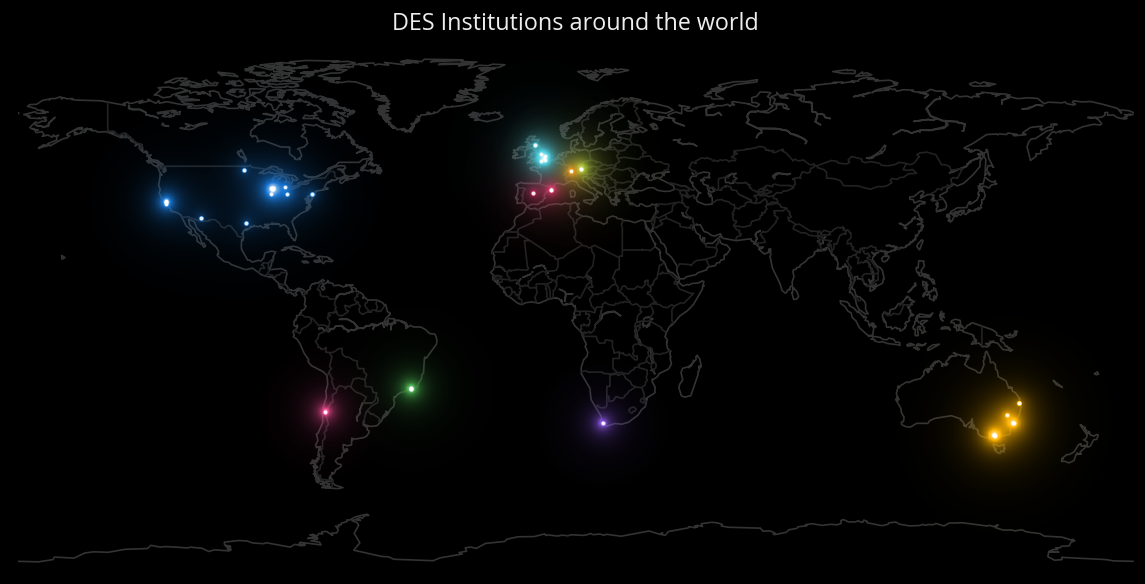

In [4]:
from matplotlib.colors import LinearSegmentedColormap as LSC

def get_shaded():
    m = get_scatter()
    # Compute the limits and mesh
    x0, y0 = m(-170, -80)
    x1, y1 = m(190, 90)
    xs, ys = np.linspace(x0, x1, 2000), np.linspace(y0, y1, 2000)
    X, Y = np.meshgrid(xs, ys)
    zs = []
    scale = 1.2  # The size of the blur

    for country in np.unique(data.country):
        # Find the colour and create a smooth colour ramp
        c = colors[country]
        cmap = LSC.from_list("fade", [c + "00", c,"#FFFFFF"], N=1000)
        subset = data.loc[data.country == country, :]
        
        # Find a vmax that looks good on all countries
        vmax = min(2, 0.7 * subset.shape[0]**0.7)
        
        # Compute the mesh values
        z = np.zeros(X.shape)
        for row in subset.itertuples(index=False):
            x, y = m(row.lat, row.long)
            dist = ((x - X)**2 + (y - Y)**2)**0.25 # Sharp falloff
            z += np.exp(-dist * scale)
        # Show the mesh and add the white dots
        m.imshow(z, origin="lower", extent=[x0,x1,y0,y1], 
                 cmap=cmap, vmax=vmax, zorder=2)
        m.scatter(subset.lat, subset.long, latlon=True, c="#FFFFFF", 
                  alpha=0.8, s=2, zorder=3)
    
    # Set the title, and make the background black
    plt.title("DES Institutions around the world", fontsize=14, 
              color="#EEEEEE", fontname="Open Sans")
    fig = plt.gcf()
    fig.patch.set_facecolor("#000000")
    return m

get_shaded();

!!!main poster

Great, well that's something I would call good enough for now. Of course... it would be better if it was animated. But that is definitely not something I intend to do in a notebook! In fact, I've done it already, you can see it below:

In [1]:
from IPython.display import Video
Video("desinstitutions/des.mp4")